## Seattle Airbnb data analysis

My choice of dataset is [Seattle Airbnb dataset](https://www.kaggle.com/datasets/airbnb/seattle).\
\
**My questions of interest**:
- How do average nightly prices vary by neighborhood? 
- What are the peak pricing months in Seattle? Do monthly average nightly price highly correlate with occupancy rate?
- How do high-rated listings compare in occupancy rate to lower-rated ones?


In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# Import datasets
calendar_df = pd.read_csv('seattle-airbnb/calendar.csv')
listings_df = pd.read_csv('seattle-airbnb/listings.csv')
reviews_df = pd.read_csv('seattle-airbnb/reviews.csv')

In [3]:
calendar_df.sample(2)

,listing_id,date,available,price
1335009,490076,2016-07-26,f,NaN
1126177,10235136,2016-06-04,f,NaN


In [4]:
min(calendar_df['date'])

'2016-01-04'

In [5]:
max(calendar_df['date'])

'2017-01-02'

In [6]:
listings_df.sample(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
3801,4524575,https://www.airbnb.com/rooms/4524575,20160104002432,2016-01-04,Comfortable Fremont Apartment,This lovely apartment is located on the lower ...,Our recently renovated apartment is perfect fo...,This lovely apartment is located on the lower ...,none,Fremont is centrally located within the city a...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,1,2.05
3509,6644760,https://www.airbnb.com/rooms/6644760,20160104002432,2016-01-04,Lakeside Suite near Beach and Shops,Lake & Mountain views paired with the best cen...,This unit is in addition to other furnished fl...,Lake & Mountain views paired with the best cen...,none,The Madison Park neighborhood is centrally loc...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,4,1.00


In [7]:
listings_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [8]:
reviews_df.sample(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
5254,6577295,38865399,2015-07-19,35247688,Gina,Yissie and Kyle were such accommodating hosts!...
52723,160222,5068002,2013-06-10,6653779,Steven,"I felt right at home in Amy's apartment, the v..."


In [9]:
min(reviews_df['date'])

'2009-06-07'

In [10]:
max(reviews_df['date'])

'2016-01-03'

- Calendar dataset date range is from *2016-01-04* to *2017-01-02*, review dataset date range is from *2009-06-07* to *2016-01-03*, so all reviews had been done before the bookings.

In [11]:
calendar_df['null_price'] = calendar_df['price'].isnull()
calendar_df[['available','null_price']].value_counts()

available  null_price
t          False         934542
f          True          459028
Name: count, dtype: int64

In [12]:
# clearn 'price' column
calendar_df['price'] = calendar_df['price'].str.replace('$', '').str.replace(',', '').astype(float)

 - The price column is null when the available column is 'f' (false), meaning the listing is occupied on those days. Therefore, the price column is only populated for unoccupied (available) days.
 - Given this information, the analysis of average nightly prices by neighborhood and peak pricing seasons is valid for available days only.

In [13]:
reviews_df.isnull().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         18
dtype: int64

- Only comments column in reviews dataset has null values and that is a normal behavior (rating without leaving any comments)

**1st question - How do average nightly prices vary by neighborhood?**


In [14]:
# Pick relevant columns
calendar_df_1 = calendar_df[['listing_id', 'date', 'price','available']]
listings_df_2 = listings_df[['id', 'neighbourhood_cleansed']]

# Join 2 datasets
calendar_listing_merged_df = pd.merge(calendar_df_1,listings_df_2, left_on= 'listing_id',right_on= 'id')

In [15]:
avg_price_by_neighborhood = calendar_listing_merged_df.groupby('neighbourhood_cleansed')['price'].mean().reset_index()
avg_price_by_neighborhood = avg_price_by_neighborhood.sort_values(by = 'price').reset_index(drop=True)
avg_price_by_neighborhood['ecdf_values'] = avg_price_by_neighborhood.index/avg_price_by_neighborhood.shape[0]
avg_price_by_neighborhood.columns = ['neighbourhood_cleansed', 'avg_price', 'ecdf_values']

In [16]:
avg_price_q1 = np.percentile(avg_price_by_neighborhood['avg_price'], 25)
avg_price_median = np.percentile(avg_price_by_neighborhood['avg_price'], 50)
avg_price_q3 = np.percentile(avg_price_by_neighborhood['avg_price'], 75)

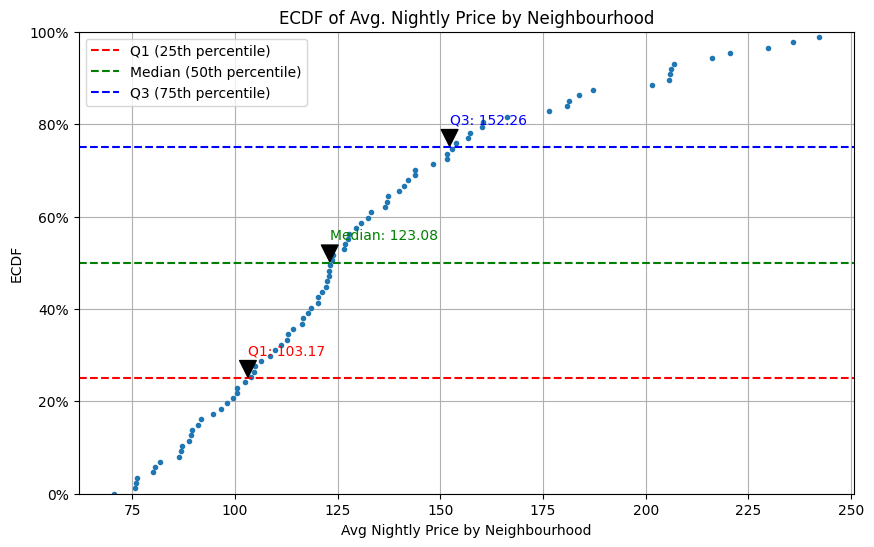

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(avg_price_by_neighborhood['avg_price'], avg_price_by_neighborhood['ecdf_values'], marker='.', linestyle='none')
plt.xlabel('Avg Nightly Price by Neighbourhood')
plt.ylabel('ECDF')
plt.title('ECDF of Avg. Nightly Price by Neighbourhood')
plt.grid(True)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
plt.ylim(0, 1)  

plt.axhline(y=0.25, color='r', linestyle='--', label='Q1 (25th percentile)')
plt.axhline(y=0.50, color='g', linestyle='--', label='Median (50th percentile)')
plt.axhline(y=0.75, color='b', linestyle='--', label='Q3 (75th percentile)')

plt.annotate(f'Q1: {avg_price_q1:.2f}', xy=(avg_price_q1, 0.25), xytext=(avg_price_q1, 0.3), 
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10, color='r')
plt.annotate(f'Median: {avg_price_median:.2f}', xy=(avg_price_median, 0.50), xytext=(avg_price_median, 0.55), 
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10, color='g')
plt.annotate(f'Q3: {avg_price_q3:.2f}', xy=(avg_price_q3, 0.75), xytext=(avg_price_q3, 0.8), 
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10, color='b')

plt.legend()
plt.show()

*5 neighborhood with highest average price nightly:*

In [18]:
avg_price_by_neighborhood[['neighbourhood_cleansed','avg_price']].sort_values(by= 'avg_price', ascending= False).head().reset_index(drop=True)

,neighbourhood_cleansed,avg_price
0,Southeast Magnolia,242.077181
1,Portage Bay,235.960789
2,Westlake,229.757911
3,Windermere,220.630903
4,Briarcliff,216.080733


*5 neighborhood with lowest average price nightly:*

In [19]:
avg_price_by_neighborhood[['neighbourhood_cleansed','avg_price']].head()

,neighbourhood_cleansed,avg_price
0,Olympic Hills,70.560796
1,Rainier Beach,75.785893
2,Georgetown,75.851073
3,South Delridge,76.237153
4,Victory Heights,79.955207


In [20]:
avg_price_by_neighborhood['avg_price'].describe()

count     87.000000
mean     132.399600
std       40.979621
min       70.560796
25%      103.166337
50%      123.083689
75%      152.257802
max      242.077181
Name: avg_price, dtype: float64

**Answer:**
- We have totally 87 neighborhoods in the dataset with avarage price ranging from ~70.56 USD/night to ~242 USD/night.
- Top 5 neighborhoods by highest average price per night are Southest Magnolia (242 USD/night), Portage Bay, Westlake, Windermere, & Briarcliff (216 USD/night)
- Top 5 neighborhoods by lowest average price per night are Victory Heights, South Delridge, Geogretown, Rainier Beach, & Olymphic Hills with avg price/prices per night are all lower than 80 USD.
- The median of each neighborhood's average price per night is 123 USD/night, 75% of neighborhood have average price per night less than 152 USD, the rest of neighborhoods has average price per night ranging from 152-242 USD

**2nd question:  What are the peak pricing months in Seattle? Do monthly average nightly price highly correlate with occupancy rate?**

In [21]:

# convert the date column to datetime
calendar_listing_merged_df['date'] = pd.to_datetime(calendar_listing_merged_df['date'])

# extract month from the date
calendar_listing_merged_df['month'] = calendar_listing_merged_df['date'].dt.month

# group by month and calculate the average price
avg_price_by_month = calendar_listing_merged_df.groupby('month')['price'].mean().reset_index()
avg_price_by_month.columns = ['month','avg_price']

# occupancy Rate
occupancy_by_month = calendar_listing_merged_df.groupby('month')['available'].apply(lambda x: (x == 'f').sum()/len(x)).reset_index()
occupancy_by_month.columns = ['month', 'occupancy_rate']

avg_price_and_occupancy_by_month = pd.merge(avg_price_by_month, occupancy_by_month, on = 'month')



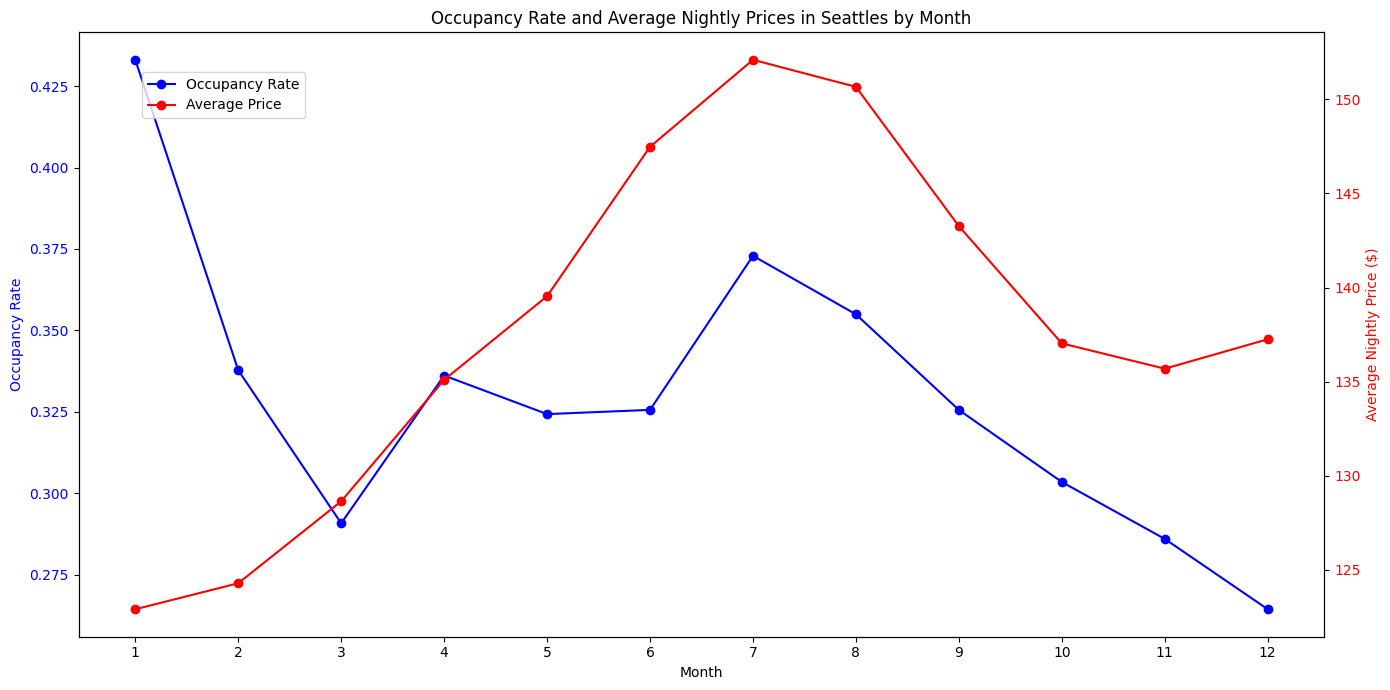

In [22]:
fig, ax1 = plt.subplots(figsize = (14, 7))

# occupancy Rate
ax1.plot(avg_price_and_occupancy_by_month['month'], avg_price_and_occupancy_by_month['occupancy_rate'], 'b', marker = 'o', label='Occupancy Rate')
ax1.set_xlabel('Month')
ax1.set_ylabel('Occupancy Rate', color = 'b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(range(1, 13))

# average Price 
ax2 = ax1.twinx()
ax2.plot(avg_price_and_occupancy_by_month['month'], avg_price_and_occupancy_by_month['avg_price'], 'r-', marker = 'o', label='Average Price')
ax2.set_ylabel('Average Nightly Price ($)', color='r')
ax2.tick_params(axis='y', labelcolor='r')


plt.title('Occupancy Rate and Average Nightly Prices in Seattles by Month')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

In [23]:
# correlation coefficient
corr_price_occupancy = avg_price_and_occupancy_by_month['occupancy_rate'].corr(avg_price_and_occupancy_by_month['avg_price'])
print(corr_price_occupancy)

-0.062419403142019804


In [24]:
# correlation coefficient from march
avg_price_and_occupancy_by_month_from_march = avg_price_and_occupancy_by_month[avg_price_and_occupancy_by_month['month'] >2 ]
corr_price_occupancy_from_march = avg_price_and_occupancy_by_month_from_march['occupancy_rate'].corr(avg_price_and_occupancy_by_month_from_march['avg_price'])
corr_price_occupancy_from_march

0.755855844126509

**Insights:**
- Although January has the highest occupancy rate, it has the lowest average nightly price in a year.
- The average nightly price is highest in three summer months, from June to August
- December has the lowest occupation rate in the whole year but its average nightly price is fairly high compared to first 4 months of the year.
- The correlation coefficient between monthly Average nightly price and monthly occupation rate is ~-0.062. This indicates a very weak negative correlation, suggesting that there is almost no linear relationship between the two variables, though looking at the chart from March to December, they seem to be correlated.

**3rd question - How do high-rated listings compare in occupancy rate to lower-rated ones?**


In [25]:
rating_df = listings_df[['id','review_scores_rating']]

In [26]:
rating_df.isnull().sum()

id                        0
review_scores_rating    647
dtype: int64

In [27]:
rating_df.shape

(3818, 2)

There are 647/3818 rows having null values in review_scores_rating column, I'm gonna drop these rows

In [28]:
rating_df = rating_df.dropna()

In [29]:
occupancy_rate_by_listing = calendar_df.groupby('listing_id')['available'].apply(lambda x: (x == 'f').sum()/len(x)).reset_index()

In [30]:
occupancy_rate_by_listing

,listing_id,available
0,3335,0.153425
1,4291,0.000000
2,5682,0.153425
3,6606,0.000000
4,7369,0.854795
...,...,...
3813,10332096,0.000000
3814,10334184,0.010959
3815,10339144,1.000000
3816,10339145,0.000000


In [31]:
occupancy_rate_rating_by_listing = pd.merge(occupancy_rate_by_listing, rating_df, left_on = 'listing_id', right_on = 'id', how='inner').drop(columns=['id'])
occupancy_rate_rating_by_listing.columns = ['listing_id','occupancy_rate','review_scores_rating']

In [32]:
occupancy_rate_rating_by_listing.sample(5)

,listing_id,occupancy_rate,review_scores_rating
2236,7110655,0.630137,94.0
2300,7308331,0.761644,96.0
2168,6958603,0.712329,96.0
2438,7601333,0.668493,92.0
1743,5913611,0.745205,91.0


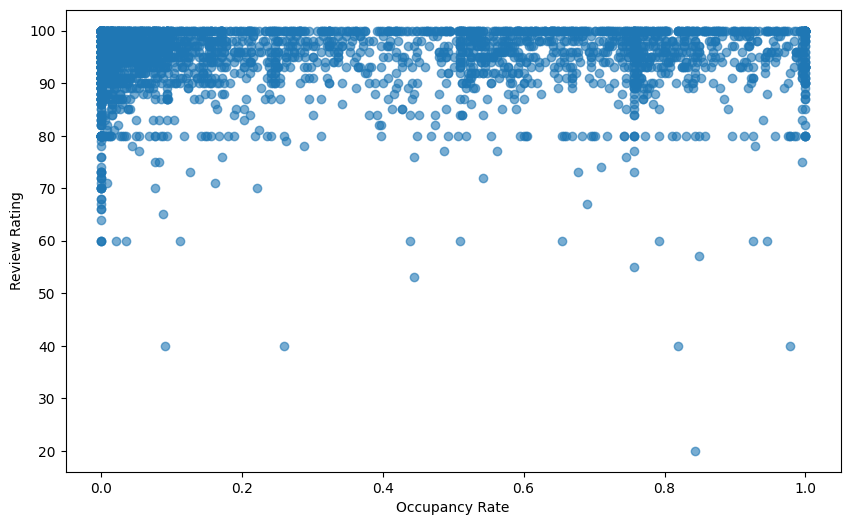

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(occupancy_rate_rating_by_listing['occupancy_rate'],occupancy_rate_rating_by_listing['review_scores_rating'],alpha = 0.6)
plt.xlabel('Occupancy Rate')
plt.ylabel('Review Rating')
plt.show()

<Axes: >

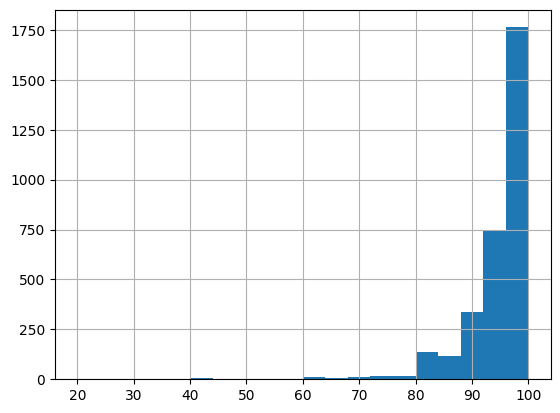

In [34]:
listings_df['review_scores_rating'].hist(bins = 20)

In [35]:
# Define high-rated and low-rated thresholds
high_rating_threshold = 95
low_rating_threshold = 80

# Categorize listings into high-rated and low-rated
occupancy_rate_rating_by_listing['rating_category'] = occupancy_rate_rating_by_listing['review_scores_rating'].apply(
    lambda x: 'High' if x >= high_rating_threshold else ('Low' if x <= low_rating_threshold else 'Medium')
)
occupancy_rate_rating_by_listing.sample(5)

,listing_id,occupancy_rate,review_scores_rating,rating_category
2885,8578490,0.394521,100.0,High
623,1856851,0.482192,95.0,High
561,1672979,0.000000,96.0,High
176,421168,0.079452,96.0,High
1324,4395654,0.857534,80.0,Low


In [36]:
# calculate average occupancy rates for each rating category
average_occupancy_rates = occupancy_rate_rating_by_listing.groupby('rating_category')['occupancy_rate'].mean().reset_index()
average_occupancy_rates


,rating_category,occupancy_rate
0,High,0.328173
1,Low,0.323711
2,Medium,0.293814


In [37]:
corr_coef_2 = occupancy_rate_rating_by_listing['occupancy_rate'].corr(occupancy_rate_rating_by_listing['review_scores_rating'])
print('Correlation coefficient of Occupancy Rate and Rating of each Listing: ', corr_coef_2)

Correlation coefficient of Occupancy Rate and Rating of each Listing:  0.0386001924089593


**Insights:**
- High-rated listings have an average occupancy rate of approximately 32.28%, Low-rated listings have an average occupancy rate of approximately 32.37%, Medium-rated listings fall in between with an average occupancy rate of approximately 29.38%.
- Correlation coefficient of Occupancy Rate and Rating of each Listing is 0.04, this indicates a very weak linear relationship between occupancy rate and listing rating.
- Possible Reasons:
    - Pricing and Location: Factors such as pricing strategy, location, and seasonality could play a more significant role in determining occupancy rates than the ratings themselves.

    - Review Volume: The number of reviews or recency of reviews might affect occupancy more than the average rating.

    - Listing Characteristics: Features like amenities, host responsiveness, and marketing could also impact occupancy rates independently of ratings.